### A Deep Learning based Efficacy Prediction System for Drug Discovery

Here shows the demo for training process

In [1]:
########################################################
# All rights reserved. 
# Author: XIE Zhengwei @ Beijing Gigaceuticals Tech Co., Ltd 
#                      @ Peking University International Cancer Institute
# Contact: xiezhengwei@gmail.com
#
#
########################################################
import os
import pdb
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

from keras import backend as K
import utils
# from densenet import DLEPS
import molecule_vae
from dleps.code.DLEPS.dti_predictor_gvae_cnn import DLEPS
# import tensorflow as tf
# from deepPurpose_CNN import CNN
import keras
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


## Note: protobuf error can be resolved by downgrading it v3.20.1

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [2]:
# Drug model

dleps_p = DLEPS()
model = dleps_p.model[0]
model.summary()

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 277, 76)      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 269, 9)       6165        input_4[0][0]                    
__________________________________________________________________________________________________
visible_1 (InputLayer)          (None, 26, 1000)     0                                            
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 261, 9)       738         conv_1[0][0]                     
_____________

In [3]:
# Load dataset

import h5py

h5f = h5py.File('../../data/drugs.h5', 'r')
drugs = h5f['data'][:]
h5f = h5py.File('../../data/proteins.h5', 'r')
proteins = h5f['data'][:]
h5f = h5py.File('../../data/pIC50.h5', 'r')
labels = h5f['data'][:]


print(drugs.shape)
print(proteins.shape)
print(labels.shape)

(18815, 277, 76)
(18815, 26, 1000)
(18815,)


In [4]:
# Clean data to remove inf, nan, if present any
drugs = utils.clean_data(drugs, fill_value=0)
proteins = utils.clean_data(proteins, fill_value=0)
labels = utils.clean_data(labels)

In [5]:
# Split dataset

drug_train, protein_train, y_train, drug_val, protein_val, y_val, drug_test, protein_test, y_test = utils.train_val_test_split(drugs, proteins, labels)


In [6]:
print(drug_train.shape)
print(protein_train.shape)
print(y_train.shape)
print(drug_val.shape)
print(protein_val.shape)
print(y_val.shape)
print(drug_test.shape)
print(protein_test.shape)
print(y_test.shape)

(13170, 277, 76)
(13170, 26, 1000)
(13170,)
(2822, 277, 76)
(2822, 26, 1000)
(2822,)
(2823, 277, 76)
(2823, 26, 1000)
(2823,)


## Leveraging transfer learning for pretrained models

In [7]:
# Freezing already trained layers
# for layers in model.layers[:-8]:
#     layers.trainable = False

In [8]:
# compile the model
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 

In [9]:
# Use ModelCheckpoint to save model and weights
from keras.callbacks import ModelCheckpoint
# filepath = "weights.best.sequential.hdf5" - best
# filepath = "weights.best.sample.hdf5"
filepath = "test.weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [10]:
# Use the final model to get a single output
epochs = 100
batch_size = 256
early_stopping = EarlyStopping(monitor='val_mae', patience=10)
history = model.fit([drug_train, protein_train], y_train, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint, early_stopping], validation_data=([drug_val, protein_val], y_val))


Train on 13170 samples, validate on 2822 samples
Epoch 1/100
13170/13170 [==============================] - 39s 3ms/step - loss: 5.7493 - mae: 1.8274 - val_loss: 4.1882 - val_mae: 1.6654

Epoch 00001: val_loss improved from inf to 4.18819, saving model to test.weights.hdf5
Epoch 2/100
13170/13170 [==============================] - 29s 2ms/step - loss: 2.5517 - mae: 1.2717 - val_loss: 4.8567 - val_mae: 1.8325

Epoch 00002: val_loss did not improve from 4.18819
Epoch 3/100
13170/13170 [==============================] - 36s 3ms/step - loss: 2.2740 - mae: 1.1869 - val_loss: 4.4062 - val_mae: 1.7540

Epoch 00003: val_loss did not improve from 4.18819
Epoch 4/100
13170/13170 [==============================] - 31s 2ms/step - loss: 2.0152 - mae: 1.1096 - val_loss: 3.2979 - val_mae: 1.4933

Epoch 00004: val_loss improved from 4.18819 to 3.29793, saving model to test.weights.hdf5
Epoch 5/100
13170/13170 [==============================] - 36s 3ms/step - loss: 1.9019 - mae: 1.0753 - val_loss: 3.5

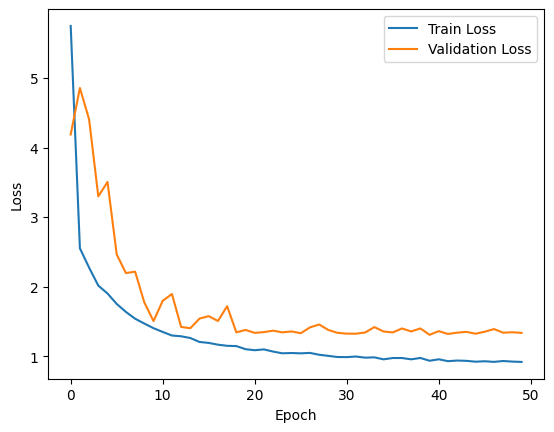

In [11]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

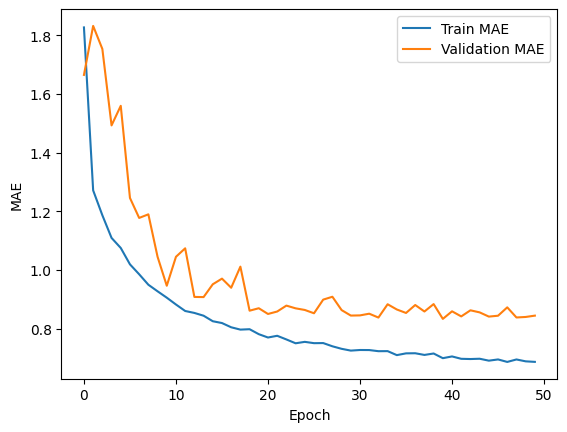

In [12]:
# Plot the training and validation MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [13]:
model.load_weights("test.weights.hdf5")

In [14]:
# Find the epoch with the minimum validation loss
optimal_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1
print(f"Optimal Epoch: {optimal_epoch} loss: {history.history['val_loss'][optimal_epoch-1]}")

Optimal Epoch: 40 loss: 1.3077822895780005


In [15]:
# Evaluate the model on the test set
results = model.evaluate([drug_test, protein_test], y_test)

2823/2823 [==============================] - 9s 3ms/step


In [16]:
# Print the evaluation results
print("Test Loss:", results[0])
print("Test MAE:", results[1])

Test Loss: 1.3098830211850883
Test MAE: 0.8333700299263


[[1.         0.72514398]
 [0.72514398 1.        ]]
0.5233332696239459


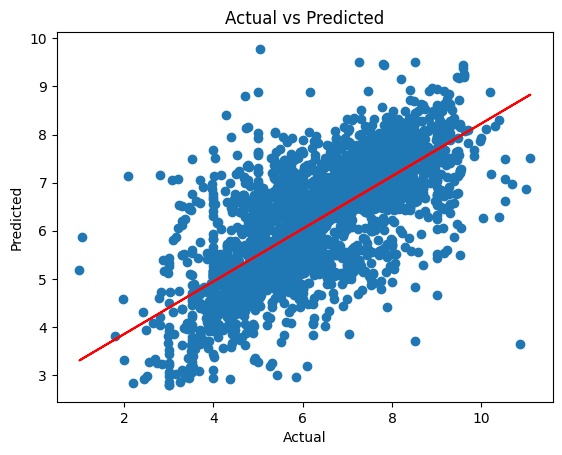

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
y_pred = model.predict([drug_test, protein_test])
print(np.corrcoef(y_test, y_pred.ravel()))
print(r2_score(y_test, y_pred))
plt.scatter(y_test, y_pred)
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m * y_test + b, 'r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

## END